## Unzip Dataset_final.zip

In [32]:
!unzip "/content/Dataset_final.zip" -d "/content" 
#!unzip "path to zip file" -d "destination path"|

Archive:  /content/Dataset_final.zip
   creating: /content/Dataset_final/
   creating: /content/Dataset_final/01_Highfive/
  inflating: /content/Dataset_final/01_Highfive/1 (1).jpg  
  inflating: /content/Dataset_final/01_Highfive/1 (10).jpg  
  inflating: /content/Dataset_final/01_Highfive/1 (100).jpg  
  inflating: /content/Dataset_final/01_Highfive/1 (101).jpg  
  inflating: /content/Dataset_final/01_Highfive/1 (102).jpg  
  inflating: /content/Dataset_final/01_Highfive/1 (103).jpg  
  inflating: /content/Dataset_final/01_Highfive/1 (104).jpg  
  inflating: /content/Dataset_final/01_Highfive/1 (105).jpg  
  inflating: /content/Dataset_final/01_Highfive/1 (106).jpg  
  inflating: /content/Dataset_final/01_Highfive/1 (107).jpg  
  inflating: /content/Dataset_final/01_Highfive/1 (108).jpg  
  inflating: /content/Dataset_final/01_Highfive/1 (109).jpg  
  inflating: /content/Dataset_final/01_Highfive/1 (11).jpg  
  inflating: /content/Dataset_final/01_Highfive/1 (110).jpg  
  inflating: 

## Data Augmentation

In [ ]:
#import dependencies
import cv2
import random
import pathlib
import glob
from google.colab.patches import cv2_imshow

#rotation function that includes how many rotation per image and where to save it
def rotation(img, angle, iter, path):
    i = 0
    filename = path[:-4] + "{}.jpg".format(i) #create unique filename
    
    for num in range(iter): #how many images per image
      angle = int(random.uniform(-angle, angle)) #get a random angle
			
			#rotate the image
      h, w = img.shape[:2]
      M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
      img = cv2.warpAffine(img, M, (w, h))
      
			#show image and save file
      cv2_imshow(img)
      cv2.imwrite(filename, img)
      i+= 1

#getting classlist
class_list = ['01_Highfive', '02_Fist', '03_Peace', '04_Fingerguns', '05_ThumbsUp']

#doing data augmentation on every class
for i in range(0,len(class_list)):
  class_name = class_list[i]
  #getting image count
  image_count = len(list(glob.glob('/content/Dataset_final/' + class_name +'/*.jpg')))

  #running data augmentation, currently all files are named 1 (1).jpg, 1 (2).jpg etc
  for j in range(1,image_count+1):
    path = '/content/Dataset_final/' + class_name + '/1 (' + str(j) +").jpg" #filename
    img = cv2.imread(path) #read image
    img = rotation(img, 45, 3, path) #perform data augmentation

cv2.waitKey(0)
cv2.destroyAllWindows()

## Preparing the Dataset

In [33]:
#Importing dependencies 
import tensorflow as tf
from tensorflow import keras
import pathlib
import glob

#Getting the path to the dataset
data_dir = pathlib.Path(r"/content/Dataset_final")

#Checking if can access dataset as well as how much data is there in total
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

#variables for our data, batch size of 32 is a standard value
#image size of 224 x 224 is based on the requirements of the VGG16 model we will be using
batch_size = 32
img_height = 224
img_width = 224

#splitting the dataset into train and validation data set
#using a validation_split of 0.2 splits the data into 80% training and 20% validation
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#to check the validation of our datatset by checking the labels of classes in our dataset
class_names = train_ds.class_names
print(class_names)

1389
Found 1389 files belonging to 5 classes.
Using 1112 files for training.
Found 1389 files belonging to 5 classes.
Using 277 files for validation.
['01_Highfive', '02_Fist', '03_Peace', '04_Fingerguns', '05_ThumbsUp']


## Visualising Dataset

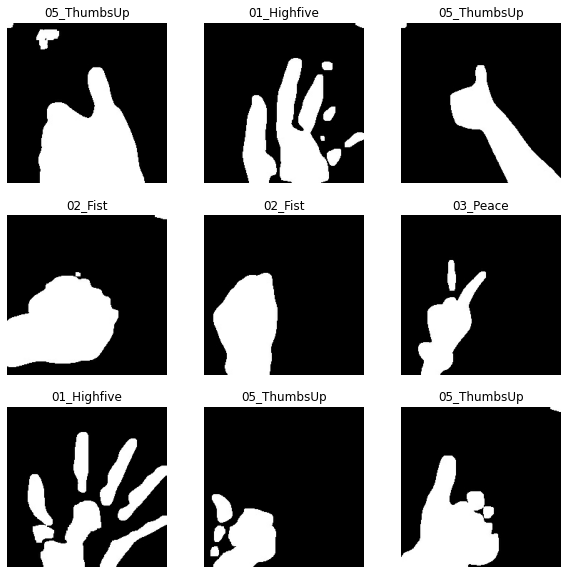

In [34]:
#import dependencies
import matplotlib.pyplot as plt

#creating the matplotlib table of 3*3 for the first 9 pics of batch #1 with their labels
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(7):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Creating the Model

In [35]:
#import dependencies
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

#loading VGG16 model
#not using any of imagenet weights due to a custom data, remove the top predictor layer
base_model = VGG16(weights= None, include_top=False, input_shape=(224,224,3)) 
base_model.trainable = True # trainable weights

#creating our own layers to add on to VGG16
flatten_layer = layers.Flatten() #flatten outputs from VGG16
dense_layer_1 = layers.Dense(50, activation='relu') #dense layer
dense_layer_2 = layers.Dense(20, activation='relu') #dense layer
prediction_layer = layers.Dense(len(class_names), activation='softmax') 
#prediction layer, the number of outputs is the number of classes we have
#this layer will determine the model prediction

In [36]:
#merging the layers together to create our Computer Vision model
model = models.Sequential([
    base_model, #VGG16
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 50)                1254450   
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 5)                 105       
                                                                 
Total params: 15,970,263
Trainable params: 15,970,263
Non-trainable params: 0
_________________________________________________________________


## Training the model

In [38]:
#import dependencies
from keras.callbacks import ModelCheckpoint

#setting the parameters for how the model will update its weights 
model.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy", "mse"],
)

#creating callback checkpoint to save the weights of the model with the least loss
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,
														  save_best_only=True, mode='auto', period=1)


In [39]:
#train the model with train_ds
model.fit(train_ds,validation_data = val_ds, batch_size=32, 
					callbacks=[checkpoint], epochs=15)

Epoch 1/15
35/35 [==============================] - ETA: 0s - loss: 21.3747 - accuracy: 0.3067 - mse: 3.8672
Epoch 1: loss improved from inf to 21.37470, saving model to best_model.hdf5
35/35 [==============================] - 37s 654ms/step - loss: 21.3747 - accuracy: 0.3067 - mse: 3.8672 - val_loss: 1.5025 - val_accuracy: 0.3863 - val_mse: 3.7360
Epoch 2/15
35/35 [==============================] - ETA: 0s - loss: 1.3678 - accuracy: 0.4613 - mse: 3.8778
Epoch 2: loss improved from 21.37470 to 1.36776, saving model to best_model.hdf5
35/35 [==============================] - 15s 437ms/step - loss: 1.3678 - accuracy: 0.4613 - mse: 3.8778 - val_loss: 1.2449 - val_accuracy: 0.5054 - val_mse: 3.7575
Epoch 3/15
35/35 [==============================] - ETA: 0s - loss: 1.0871 - accuracy: 0.6286 - mse: 3.9033
Epoch 3: loss improved from 1.36776 to 1.08706, saving model to best_model.hdf5
35/35 [==============================] - 15s 437ms/step - loss: 1.0871 - accuracy: 0.6286 - mse: 3.9033 - va

## Save Model

In [40]:
#Saving the model data
model.save("my_model2")

In [ ]:

#If you want to download your model onto your computer (model will be lost the moment
#you disconnect your Google Colab Runtime), you will need to zip the folder and then
#right click the file to download it in the file explorer (file icon on the left)
!zip -r "/content/my_model.zip" "/content/my_model"

## Load Model

In [5]:
#if you want to access your model after a NEW runtime, upload the zip file into 
#Google Colab (just like how you upload your dataset) and run the unzip code 
!unzip "/content/my_model.zip" -d "/content"

Archive:  /content/my_model.zip
   creating: /content/content/my_model/
  inflating: /content/content/my_model/keras_metadata.pb  
  inflating: /content/content/my_model/saved_model.pb  
   creating: /content/content/my_model/variables/
  inflating: /content/content/my_model/variables/variables.data-00000-of-00001  
  inflating: /content/content/my_model/variables/variables.index  
   creating: /content/content/my_model/assets/
 extracting: /content/content/my_model/fingerprint.pb  


## Access to Webcam

In [4]:
#import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

#Helper Functions
#function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  #decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  #convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  #decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

#function to convert OpenCV Rectangle bounding box image into base64 byte string 
#to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video 
					stream.
  Returns:
        bytes: Base64 image byte string
  """
  #convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  #format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  #format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 
							 'utf-8')))

  return bbox_bytes

In [3]:
#JavaScript to properly create our live video stream using our webcam as input

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

## Accessing Firebase

In [1]:
#importing dependencies
import firebase_admin
from firebase_admin import credentials
from firebase_admin import db

#tetch the service account key JSON file contents
cred = credentials.Certificate('secrets.json') #path to secrets.json file

#initialize the app with a service account, granting admin privileges
firebase_admin.initialize_app(cred, {
    'databaseURL': 'https://pds-lab-ef8a8-default-rtdb.firebaseio.com' #database URL 
})

#checking if led database exist, if it doesn't create one with default value 0
ref = db.reference("/led")
if ref.get() == None:
	db.reference("/").set({"led":0})

Testing Model with Webcam

In [ ]:
#importing dependencies
import cv2
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras
from google.colab.patches import cv2_imshow

#start streaming video from webcam 
video_stream()

#label for video
label_html = 'Capturing...'

#initialze bounding box to empty
bbox = ""

#reading from live webcam
js_reply = video_frame(label_html, bbox) 

#getting the background image for masking 
#same algorithm as dataset collection but using functions from the javascript code
first = js_to_image(js_reply["img"]) 
first_crop = first[100:324, 400:624] 
first_gray = cv2.cvtColor(first_crop, cv2.COLOR_BGR2GRAY)
first_gray = cv2.GaussianBlur(first_gray, (21, 21), 0)

#loading the Computer Vision model
reconstructed_model = keras.models.load_model("/content/my_model2") #path to model

#the 5 different predictions outputs the model is trained on
class_names = ['01_Highfive', '02_Fist', '03_Peace', '04_Fingerguns', '05_ThumbsUp']

#while the webcam is running
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply: #if the webcam stop running, break the for code 
        break

	  #drawing the box on top of the live webcam
    #create a transparent overlay on the whole frame then draw a rectangle on the overlay
    #allows user to know where to the hand gestures will be recognised
    bbox_a = np.zeros([480,640,4], dtype=np.uint8) 
    bbox_array = cv2.rectangle(bbox_a,(424,100), (624,300), (255,0,0), 2)
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    bbox = bbox_to_bytes(bbox_array)

		#get the frame from the live webcam and crop the image according to bounding box
    img = js_to_image(js_reply["img"])   
    frame_rect = img[100:324, 400:624]

    #create the masked image for model to predict (same code creating dataset)
    gray = cv2.cvtColor(frame_rect, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (21, 21), 0) 
    difference = cv2.absdiff(gray, first_gray)
    thresh = cv2.threshold(difference, 10, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.dilate(thresh, None, iterations=2)
		
		#convert image into data for the model to predict
    img_array = tf.keras.utils.img_to_array(thresh)
    img_array = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
    #cv2_imshow(img_array)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    #run the model to get the predictions 
    #predictions will return the confidence level of each class for the image 
    #the image with the highest confidence level is the predicted value
    predictions = reconstructed_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

		#updating Firebase data based on the model prediction
    if np.argmax(score) == 0: #if high five, set 1
      ref = db.reference('/led') 
      ref.set(1)

    elif np.argmax(score) == 1: #if fist, set 0
      ref = db.reference('/led')
      ref.set(0)
    #print(db.reference('/led').get())
    
		#wait for 1s than repeat
    time.sleep(0.5)